<a href="https://colab.research.google.com/github/F1roz/quantum_clip/blob/main/QuantumCLIP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install pennylane --upgrade

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 19.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 930.0/930.0 kB 24.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 33.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 26.0 MB/s eta 0:00:00


In [ ]:
pip install medmnist

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.2/87.2 kB 4.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for fire: filename=fire-0.7.0-py3-none-any.whl size=114249 sha256=d68c37e6a64ea90a52f186384669385893dc0d28f931f33acd8163f785e73275
  Stored in directory: /root/.cache/pip/wheels/19/39/2f/2d3cadc408a8804103f1c34ddd4b9f6a93497b11fa96fe738e
Successfully built fire


In [ ]:
!pip install scikit-learn --upgrade

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.5/13.5 MB 48.4 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.6.0
    Uninstalling scikit-learn-1.6.0:
      Successfully uninstalled scikit-learn-1.6.0


100%|██████████| 560k/560k [00:00<00:00, 1.04MB/s]


Using downloaded and verified file: /root/.medmnist/breastmnist.npz
Training samples: 546
Test samples: 156
Image shape: (546, 28, 28)
Labels shape: (546, 1)


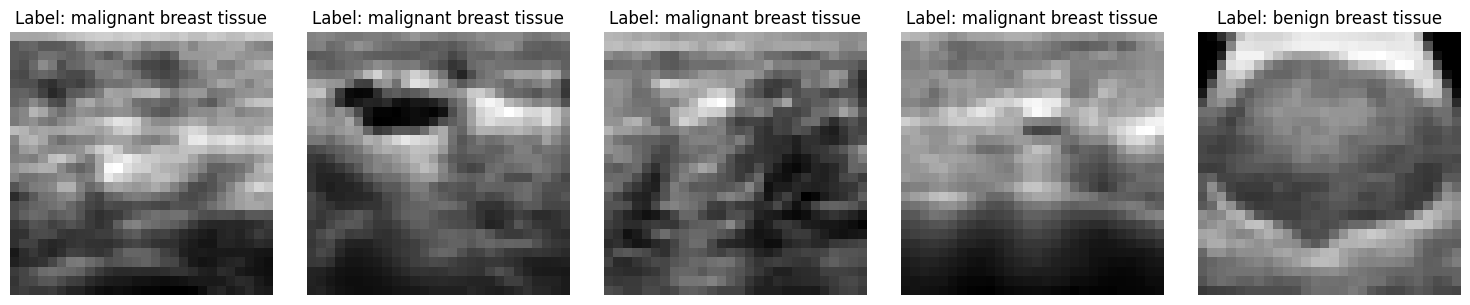


First few labels: [1 1 1 1 0 1 1 1 0 1]


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from medmnist import BreastMNIST
import torch
from torchvision import transforms

# Load the dataset
data_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[.5], std=[.5])
])

# Load train dataset
train_dataset = BreastMNIST(split='train', transform=data_transform, download=True)
test_dataset = BreastMNIST(split='test', transform=data_transform, download=True)

# Print dataset info
print(f"Training samples: {len(train_dataset)}")
print(f"Test samples: {len(test_dataset)}")
print(f"Image shape: {train_dataset.imgs.shape}")
print(f"Labels shape: {train_dataset.labels.shape}")

# Define captions for visualization
captions = {
    0: "benign breast tissue",
    1: "malignant breast tissue"
}

# Visualize some samples
def show_samples(dataset, num_samples=5):
    plt.figure(figsize=(15, 3))
    for i in range(num_samples):
        image, label = dataset[i]
        plt.subplot(1, num_samples, i + 1)
        plt.imshow(image.squeeze(), cmap='gray')
        plt.title(f"Label: {captions[label.item()]}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Show samples
show_samples(train_dataset)

# Print first few labels
print("\nFirst few labels:", train_dataset.labels[:10].squeeze())

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from transformers import BertTokenizer, BertModel
import pennylane as qml
import numpy as np
from medmnist import BreastMNIST
from torchvision import transforms
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score  # Evaluation metrics
import os
from PIL import Image
import seaborn as sns
from typing import List, Dict, Tuple
import logging
from sklearn.model_selection import KFold
from sklearn.utils import resample
import copy
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Configure logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

# Global configurations
n_qubits = 4
dev = qml.device("default.qubit", wires=n_qubits)

class TorchQuantumCircuit(nn.Module):

    def __init__(self, n_qubits: int, n_layers: int = 1):
        super().__init__()
        self.n_qubits = n_qubits
        self.n_layers = n_layers

        # Trainable parameters for rotation gates
        self.weights = nn.Parameter(torch.randn(n_layers, n_qubits, 3))

        # Define quantum device and circuit
        self.dev = qml.device("default.qubit", wires=n_qubits)

        @qml.qnode(self.dev, interface="torch", diff_method="parameter-shift")
        def quantum_circuit(inputs, weights):
            # State preparation
            for i in range(self.n_qubits):
                qml.RY(inputs[i], wires=i)

            # Trainable layers
            for layer in range(self.n_layers):
                # Rotation gates
                for i in range(self.n_qubits):
                    qml.RX(weights[layer, i, 0], wires=i)
                    qml.RY(weights[layer, i, 1], wires=i)
                    qml.RZ(weights[layer, i, 2], wires=i)

                # Entanglement
                for i in range(self.n_qubits - 1):
                    qml.CNOT(wires=[i, i + 1])

            # Measurements
            return [qml.expval(qml.PauliZ(i)) for i in range(self.n_qubits)]

        self.quantum_circuit = quantum_circuit

    def forward(self, x: torch.Tensor) -> torch.Tensor:

        batch_size = x.shape[0]
        device = x.device

        # Process each input in the batch
        results = []
        for i in range(batch_size):
            # Move to CPU for PennyLane processing
            inputs = x[i].cpu().detach().numpy()

            # Run quantum circuit
            output = self.quantum_circuit(inputs, self.weights)
            results.append(torch.tensor(output, dtype=torch.float32))

        # Stack results and move to original device
        return torch.stack(results).to(device)

In [ ]:
# Part 2: QuantumCLIP Implementation

class QuantumCLIP(nn.Module):
    def __init__(self,
                 temperature: float = 0.07,
                 n_qubits: int = 4,
                 n_layers: int = 1,
                 embedding_dim: int = 512):
        super().__init__()
        self.temperature = temperature
        self.embedding_dim = embedding_dim

        # Text encoder
        self.tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
        self.text_encoder = BertModel.from_pretrained('bert-base-uncased')
        self.text_projection = nn.Linear(768, embedding_dim)

        # Image encoder with quantum circuit
        self.image_encoder = nn.Sequential(
            nn.Linear(28*28, 128, dtype=torch.float32),
            nn.ReLU(),
            nn.Linear(128, 64, dtype=torch.float32),
            nn.ReLU(),
            nn.Linear(64, n_qubits, dtype=torch.float32),
            nn.Tanh(),  # Normalize inputs to quantum circuit
            TorchQuantumCircuit(n_qubits=n_qubits, n_layers=n_layers),
            nn.Linear(n_qubits, embedding_dim, dtype=torch.float32)
        )


        # Temperature parameter
        self.logit_scale = nn.Parameter(torch.ones([]) * np.log(1 / temperature))

        # Initialize weights
        self.apply(self._init_weights)

    def _init_weights(self, module):

        if isinstance(module, nn.Linear):
            torch.nn.init.xavier_uniform_(module.weight)
            if module.bias is not None:
                torch.nn.init.constant_(module.bias, 0)

    def encode_text(self, text: List[str]) -> torch.Tensor:
        # Tokenize and encode text
        text_tokens = self.tokenizer(
            text,
            padding=True,
            truncation=True,
            max_length=77,
            return_tensors="pt"
        ).to(next(self.parameters()).device)

        # Get text features
        text_features = self.text_encoder(**text_tokens).last_hidden_state[:, 0, :]
        text_features = self.text_projection(text_features)

        return nn.functional.normalize(text_features, dim=-1)

    def encode_image(self, image: torch.Tensor) -> torch.Tensor:
        # Flatten and encode image
        image_features = self.image_encoder(image.view(-1, 28*28))
        return nn.functional.normalize(image_features, dim=-1)

    def forward(self, image: torch.Tensor, text: List[str]) -> Tuple[torch.Tensor, torch.Tensor]:
        # Get image and text features
        image_features = self.encode_image(image)
        text_features = self.encode_text(text)

        # Calculate similarity
        logit_scale = self.logit_scale.exp()
        logits_per_image = logit_scale * image_features @ text_features.t()
        logits_per_text = logits_per_image.t()

        return logits_per_image, logits_per_text

In [ ]:
class BreastDataset(Dataset):
    def __init__(self, split='train'):
        # Initialize and download the BreastMNIST dataset
        data = BreastMNIST(split=split, download=True)
        self.images = data.imgs
        self.labels = data.labels
        # Define image transformations
        self.transform = transforms.Compose([
            transforms.ToTensor(),
        ])

        # Define detailed class descriptions for mammogram findings
        self.class_descriptions = {
            'normal': "This mammogram shows normal breast tissue with no suspicious findings or abnormalities",
            'malignant': "This mammogram shows suspicious findings indicating possible breast cancer with abnormal tissue patterns"
        }

        # Initialize lists for storing descriptions and labels
        self.descriptions = []
        self.binary_labels = []

        # Process each image's label and create corresponding description
        for label in self.labels:
            # Convert tensor to boolean (0 = normal, 1 = malignant)
            is_malignant = bool(label.item())
            # Get corresponding description
            description = self.class_descriptions['malignant' if is_malignant else 'normal']

            # Store description and label
            self.descriptions.append(description)
            self.binary_labels.append(int(is_malignant))

    def __len__(self):
        # Return total number of samples
        return len(self.images)

    def __getitem__(self, idx):
        # Get single item from dataset
        image = self.transform(self.images[idx])  # Transform image to tensor
        text = self.descriptions[idx]             # Get corresponding description
        label = self.binary_labels[idx]          # Get binary label
        return image, text, label

def calculate_similarity_metrics(logits_per_image):
    """
    Calculate various similarity metrics between image and text pairs
    """
    # Get batch size from input
    batch_size = logits_per_image.size(0)

    # Calculate similarity for matched pairs (diagonal elements)
    diagonal_similarities = torch.diagonal(logits_per_image)
    avg_matched_similarity = diagonal_similarities.mean().item()

    # Calculate similarity for unmatched pairs (non-diagonal elements)
    mask = ~torch.eye(batch_size, dtype=bool, device=logits_per_image.device)
    unmatched_similarities = logits_per_image[mask]
    avg_unmatched_similarity = unmatched_similarities.mean().item()

    # Return computed metrics
    return {
        'avg_matched_similarity': avg_matched_similarity,
        'avg_unmatched_similarity': avg_unmatched_similarity,
        'similarity_ratio': avg_matched_similarity / avg_unmatched_similarity
    }

def evaluate_model(model, val_loader, device):

    model.eval()  # Set model to evaluation mode

    # Initialize lists for storing predictions and actual labels
    all_preds = []
    all_labels = []
    all_similarity_metrics = []

    # Disable gradient computation for evaluation
    with torch.no_grad():
        for images, texts, labels in val_loader:
            # Move images to device (GPU/CPU)
            images = images.to(device)

            # Get model predictions
            logits_per_image, _ = model(images, texts)

            # Convert logits to binary predictions
            preds = (logits_per_image.argmax(dim=1) == 1).cpu().numpy()
            labels = np.array(labels)

            # Calculate similarity metrics for this batch
            similarity_metrics = calculate_similarity_metrics(logits_per_image)
            all_similarity_metrics.append(similarity_metrics)

            # Store predictions and labels
            all_preds.extend(preds)
            all_labels.extend(labels)

    # Calculate classification metrics
    metrics = {
        'accuracy': accuracy_score(all_labels, all_preds),
        'precision': precision_score(all_labels, all_preds, average='binary'),
        'recall': recall_score(all_labels, all_preds, average='binary'),
        'f1': f1_score(all_labels, all_preds, average='binary')
    }

    # Calculate average similarity metrics across all batches
    avg_similarity_metrics = {
        'avg_matched_similarity': np.mean([m['avg_matched_similarity'] for m in all_similarity_metrics]),
        'avg_unmatched_similarity': np.mean([m['avg_unmatched_similarity'] for m in all_similarity_metrics]),
        'similarity_ratio': np.mean([m['similarity_ratio'] for m in all_similarity_metrics])
    }

    # Combine all metrics
    metrics.update(avg_similarity_metrics)
    return metrics

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, SubsetRandomSampler
from sklearn.model_selection import ParameterGrid

def train_quantum_clip(): #hyperparameter tuning added, cross validation, early stopping

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    # Hyperparameter grid
    param_grid = {
        'learning_rate': [0.001, 0.0005, 0.0001],
        'batch_size': [16, 32],
        'weight_decay': [0.01, 0.001],
        'temperature': [0.07, 0.1]
    }

    # Cross-validation setup
    n_splits = 5
    kfold = KFold(n_splits=n_splits, shuffle=True)

    # Early stopping parameters
    early_stopping_patience = 5
    best_val_loss = float('inf')
    patience_counter = 0

    # Track best model and parameters
    best_model = None
    best_params = None
    best_metrics = None
    best_overall_f1 = 0.0

    # Dataset preparation
    dataset = BreastDataset(split='train')

    criterion = nn.CrossEntropyLoss()

    for params in ParameterGrid(param_grid):
        print(f"\nTrying parameters: {params}")
        cv_metrics = []

        # Cross-validation loop
        for fold, (train_idx, val_idx) in enumerate(kfold.split(dataset)):
            print(f"\nFold {fold + 1}/{n_splits}")

            # Create data loaders for this fold
            train_subsampler = SubsetRandomSampler(train_idx)
            val_subsampler = SubsetRandomSampler(val_idx)

            train_loader = DataLoader(
                dataset,
                batch_size=params['batch_size'],
                sampler=train_subsampler
            )
            val_loader = DataLoader(
                dataset,
                batch_size=params['batch_size'],
                sampler=val_subsampler
            )

            # Initialize model
            model = QuantumCLIP(temperature=params['temperature']).to(device)

            # Initialize optimizer and scheduler
            optimizer = optim.Adam(
                model.parameters(),
                lr=params['learning_rate'],
                weight_decay=params['weight_decay']
            )

            # Learning rate scheduler
            scheduler = optim.lr_scheduler.ReduceLROnPlateau(
                optimizer,
                mode='min',
                factor=0.5,
                patience=2,
                verbose=True
            )

            # Training history
            history = {
                'train_loss': [],
                'val_metrics': []
            }

            # Training loop
            for epoch in range(5):  # Max epochs
                # Training phase
                model.train()
                total_loss = 0

                for batch_idx, (images, texts, _) in enumerate(train_loader):
                    images = images.to(device)

                    optimizer.zero_grad()
                    logits_per_image, logits_per_text = model(images, texts)

                    ground_truth = torch.arange(len(images)).to(device)
                    loss = (criterion(logits_per_image, ground_truth) +
                           criterion(logits_per_text, ground_truth)) / 2

                    loss.backward()
                    optimizer.step()

                    total_loss += loss.item()

                avg_loss = total_loss / len(train_loader)
                history['train_loss'].append(avg_loss)

                # Validation phase
                val_metrics = evaluate_model(model, val_loader, device)
                history['val_metrics'].append(val_metrics)

                # Learning rate scheduling
                scheduler.step(avg_loss)

                # Early stopping check
                if avg_loss < best_val_loss:
                    best_val_loss = avg_loss
                    patience_counter = 0
                else:
                    patience_counter += 1

                if patience_counter >= early_stopping_patience:
                    print("Early stopping triggered")
                    break

                print(f"Epoch {epoch}: Loss = {avg_loss:.4f}, F1 = {val_metrics['f1']:.4f}")

            # Store fold metrics
            cv_metrics.append(val_metrics)

        # Calculate average metrics across folds
        avg_metrics = {
            metric: np.mean([fold[metric] for fold in cv_metrics])
            for metric in cv_metrics[0].keys()
        }

        print("\nAverage metrics across folds:")
        for metric, value in avg_metrics.items():
            print(f"{metric}: {value:.4f}")

        # Update best model if better
        if avg_metrics['f1'] > best_overall_f1:
            best_overall_f1 = avg_metrics['f1']
            best_model = copy.deepcopy(model)
            best_params = params
            best_metrics = avg_metrics

    # Save best model and parameters
    torch.save({
        'model_state_dict': best_model.state_dict(),
        'hyperparameters': best_params,
        'metrics': best_metrics
    }, 'best_quantum_clip_model.pth')

    print("\nBest hyperparameters:", best_params)
    print("\nBest metrics:", best_metrics)

    return best_model, best_params, best_metrics

# Main execution
if __name__ == "__main__":
    best_model, best_params, best_metrics = train_quantum_clip()

    # Test evaluation
    test_dataset = BreastDataset(split='test')
    test_loader = DataLoader(test_dataset, batch_size=32)

    test_metrics = evaluate_model(best_model, test_loader, device)
    print("\nTest Results with Best Model:")
    for metric, value in test_metrics.items():
        print(f"{metric}: {value:.4f}")

    # Visualize predictions
    visualize_predictions(best_model, test_loader, device)

Using device: cpu
Using downloaded and verified file: /root/.medmnist/breastmnist.npz

Trying parameters: {'batch_size': 16, 'learning_rate': 0.001, 'temperature': 0.07, 'weight_decay': 0.01}

Fold 1/5
Epoch 0: Loss = 2.7275, F1 = 0.2083
Epoch 1: Loss = 2.7243, F1 = 0.2857
Epoch 2: Loss = 2.7244, F1 = 0.2857
Epoch 3: Loss = 2.7229, F1 = 0.2857
Epoch 4: Loss = 2.7235, F1 = 0.2128

Fold 2/5
Epoch 0: Loss = 2.7365, F1 = 0.2083
Epoch 1: Loss = 2.7356, F1 = 0.3119
Epoch 2: Loss = 2.7331, F1 = 0.3137
Early stopping triggered

Fold 3/5
Early stopping triggered

Fold 4/5
Early stopping triggered

Fold 5/5
Early stopping triggered

Average metrics across folds:
accuracy: 0.3499
precision: 0.6196
recall: 0.1722
f1: 0.2570
avg_matched_similarity: -2.2697
avg_unmatched_similarity: -2.2697
similarity_ratio: 0.9995

Trying parameters: {'batch_size': 16, 'learning_rate': 0.001, 'temperature': 0.07, 'weight_decay': 0.001}

Fold 1/5
Early stopping triggered

Fold 2/5
Early stopping triggered

Fold 3/5


Using downloaded and verified file: /root/.medmnist/breastmnist.npz
Using downloaded and verified file: /root/.medmnist/breastmnist.npz
Epoch: 0, Batch: 0, Loss: 3.4773
Epoch: 0, Batch: 10, Loss: 3.4682

Epoch 0 completed:
Average Loss: 3.3168
Validation Metrics:
Accuracy: 0.4615
Precision: 0.8000
Recall: 0.3509
F1 Score: 0.4878
Similarity Ratio: 1.0031
--------------------------------------------------
Epoch: 1, Batch: 0, Loss: 3.4184
Epoch: 1, Batch: 10, Loss: 3.4541

Epoch 1 completed:
Average Loss: 3.3101
Validation Metrics:
Accuracy: 0.3974
Precision: 0.8125
Recall: 0.2281
F1 Score: 0.3562
Similarity Ratio: 1.0002
--------------------------------------------------
Epoch: 2, Batch: 0, Loss: 3.4677
Epoch: 2, Batch: 10, Loss: 3.4627

Epoch 2 completed:
Average Loss: 3.3121
Validation Metrics:
Accuracy: 0.3718
Precision: 0.6818
Recall: 0.2632
F1 Score: 0.3797
Similarity Ratio: 1.0003
--------------------------------------------------
Epoch: 3, Batch: 0, Loss: 3.4633
Epoch: 3, Batch: 1

NameError: name 'malignant_prob' is not defined

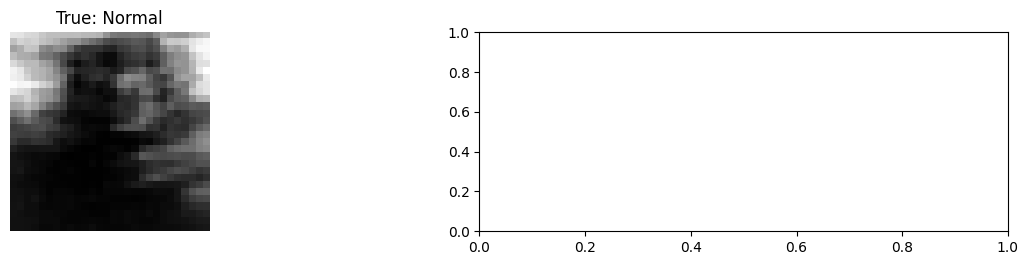

In [ ]:
def train_quantum_clip(): #without hyperparameter tuning


    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    model = QuantumCLIP().to(device)

    # Initialize datasets
    train_dataset = BreastDataset(split='train')
    val_dataset = BreastDataset(split='val')

    # Create data loaders
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

    # Initialize loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=5e-5)

    # Initialize dictionary to store training history
    history = {
        'train_loss': [],
        'val_metrics': []
    }

    # Training loop
    num_epochs = 5
    for epoch in range(num_epochs):
        model.train()  # Set model to training mode
        total_loss = 0

        # Batch training
        for batch_idx, (images, texts, _) in enumerate(train_loader):
            # Move images to device
            images = images.to(device)

            # Zero gradients
            optimizer.zero_grad()

            # Forward pass
            logits_per_image, logits_per_text = model(images, texts)

            # Calculate ground truth (diagonal matrix)
            ground_truth = torch.arange(len(images)).to(device)

            # Calculate symmetric loss (image-to-text and text-to-image)
            loss = (criterion(logits_per_image, ground_truth) +
                   criterion(logits_per_text, ground_truth)) / 2

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

            # Print progress every 10 batches
            if batch_idx % 10 == 0:
                print(f"Epoch: {epoch}, Batch: {batch_idx}, Loss: {loss.item():.4f}")

        # Calculate average loss for epoch
        avg_loss = total_loss / len(train_loader)
        history['train_loss'].append(avg_loss)

        # Evaluate on validation set
        val_metrics = evaluate_model(model, val_loader, device)
        history['val_metrics'].append(val_metrics)

        # Print epoch summary
        print(f"\nEpoch {epoch} completed:")
        print(f"Average Loss: {avg_loss:.4f}")
        print(f"Validation Metrics:")
        print(f"Accuracy: {val_metrics['accuracy']:.4f}")
        print(f"Precision: {val_metrics['precision']:.4f}")
        print(f"Recall: {val_metrics['recall']:.4f}")
        print(f"F1 Score: {val_metrics['f1']:.4f}")
        print(f"Similarity Ratio: {val_metrics['similarity_ratio']:.4f}")
        print("-" * 50)

    # Visualization of training history
    def plot_training_history():
        plt.figure(figsize=(15, 5))

        # Plot training loss
        plt.subplot(1, 3, 1)
        plt.plot(history['train_loss'])
        plt.title('Training Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')

        # Plot classification metrics
        plt.subplot(1, 3, 2)
        metrics = ['accuracy', 'precision', 'recall', 'f1']
        for metric in metrics:
            values = [epoch_metrics[metric] for epoch_metrics in history['val_metrics']]
            plt.plot(values, label=metric)
        plt.title('Classification Metrics')
        plt.xlabel('Epoch')
        plt.ylabel('Score')
        plt.legend()

        # Plot similarity metrics
        plt.subplot(1, 3, 3)
        plt.plot([m['similarity_ratio'] for m in history['val_metrics']],
                label='Similarity Ratio')
        plt.title('Similarity Metrics')
        plt.xlabel('Epoch')
        plt.ylabel('Ratio')
        plt.legend()

        plt.tight_layout()
        plt.savefig('training_history.png')
        plt.close()

    # Plot the training history
    plot_training_history()

    return model, history

def visualize_predictions(model, test_loader, device, num_samples=5):

    model.eval()

    # Get sample batch
    images, texts, labels = next(iter(test_loader))
    images = images.to(device)[:num_samples]
    texts = texts[:num_samples]
    labels = labels[:num_samples]

    with torch.no_grad():
        logits_per_image, _ = model(images, texts)
        probs = torch.softmax(logits_per_image, dim=1)

    # Plot results
    plt.figure(figsize=(15, 3*num_samples))
    for idx in range(num_samples):
        plt.subplot(num_samples, 2, 2*idx + 1)
        plt.imshow(images[idx].cpu().squeeze(), cmap='gray')
        plt.title(f"True: {'Malignant' if labels[idx] else 'Normal'}")
        plt.axis('off')

        plt.subplot(num_samples, 2, 2*idx + 2)
        plt.bar(['Normal', 'Malignant'], [1 - malignant_prob, malignant_prob])
        plt.title('Prediction Probabilities')

    plt.tight_layout()
    plt.savefig('predictions_visualization.png')
    plt.close()

# Main execution
if __name__ == "__main__":
    # Train model
    model, history = train_quantum_clip()

    # Save model
    torch.save(model.state_dict(), 'quantum_clip_model.pth')

    # Create test dataset and loader
    test_dataset = BreastDataset(split='test')
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

    # Evaluate on test set
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    test_metrics = evaluate_model(model, test_loader, device)

    # Print final test results
    print("\nFinal Test Results:")
    print(f"Accuracy: {test_metrics['accuracy']:.4f}")
    print(f"Precision: {test_metrics['precision']:.4f}")
    print(f"Recall: {test_metrics['recall']:.4f}")
    print(f"F1 Score: {test_metrics['f1']:.4f}")
    print(f"Similarity Ratio: {test_metrics['similarity_ratio']:.4f}")

    # Visualize predictions
    visualize_predictions(model, test_loader, device)

In [ ]:
def plot_breast_similarity(model, test_loader, device, num_samples=5):



    # Get breast images and their descriptions
    images, texts, labels = next(iter(test_loader))
    images = images[:num_samples].to(device)
    texts = texts[:num_samples]

    # Create simplified descriptions for visualization
    short_texts = [
        "Normal" if label == 0 else "Malignant"
        for label in labels[:num_samples]
    ]

    with torch.no_grad():
        # Get image and text features
        image_features = model.visual_encoder(images.view(-1, 28*28))
        text_inputs = model.tokenizer(texts, padding=True, truncation=True, return_tensors="pt").to(device)
        text_features = model.text_encoder(**text_inputs).last_hidden_state[:, 0, :]

        # Normalize features
        image_features /= image_features.norm(dim=-1, keepdim=True)
        text_features /= text_features.norm(dim=-1, keepdim=True)

        # Calculate similarity
        similarity = text_features.cpu().numpy() @ image_features.cpu().numpy().T

    # Plot
    plt.figure(figsize=(20, 14))
    plt.imshow(similarity, vmin=0.1, vmax=0.3)
    plt.yticks(range(len(short_texts)), short_texts, fontsize=18)
    plt.xticks([])

    # Display breast images below
    for i, img in enumerate(images):
        plt.imshow(img.cpu().squeeze(), extent=(i-0.5, i+0.5, -1.6, -0.6), cmap='gray')

    # Add similarity values
    for i in range(similarity.shape[1]):
        for j in range(similarity.shape[0]):
            plt.text(i, j, f"{similarity[j, i]:.2f}", ha="center", va="center", size=12)

    plt.title("Breast Image-Text Similarity (Quantum-CLIP)", size=20)
    plt.tight_layout()
    plt.savefig('breast_similarity.png')
    plt.close()

# Usage
plot_breast_similarity(model, test_loader, device)

In [ ]:
#hyperparameter tuning

from sklearn.model_selection import ParameterGrid
import json
from datetime import datetime

def hyperparameter_tuning():

    # Define hyperparameter grid
    param_grid = {
        'learning_rate': [1e-5, 5e-5, 1e-4],
        'batch_size': [16, 32, 64],
        'temperature': [0.01, 0.07, 0.1],
        'n_qubits': [4, 6, 8],
        'quantum_layers': [1, 2, 3],  # Number of quantum circuit layers
        'projection_dim': [256, 512, 1024]  # Dimension of the projection space
    }

    # Initialize results dictionary
    results = []

    # Create parameter combinations
    param_combinations = list(ParameterGrid(param_grid))

    # Create validation dataset
    val_dataset = BreastDataset(split='val')

    # Loop through parameter combinations
    for params in param_combinations:
        try:
            print(f"\nTesting parameters: {params}")

            # Create model with current parameters
            model = QuantumCLIP(
                temperature=params['temperature'],
                n_qubits=params['n_qubits'],
                quantum_layers=params['quantum_layers'],
                projection_dim=params['projection_dim']
            ).to(device)

            # Create data loaders
            train_dataset = BreastDataset(split='train')
            train_loader = DataLoader(train_dataset,
                                    batch_size=params['batch_size'],
                                    shuffle=True)
            val_loader = DataLoader(val_dataset,
                                  batch_size=params['batch_size'],
                                  shuffle=False)

            # Initialize optimizer
            optimizer = optim.Adam(model.parameters(), lr=params['learning_rate'])

            # Train for a few epochs
            num_epochs = 5  # Reduced epochs for quick evaluation
            best_val_metrics = train_and_evaluate(
                model, train_loader, val_loader, optimizer, num_epochs
            )

            # Store results
            result = {
                'parameters': params,
                'metrics': best_val_metrics,
                'timestamp': datetime.now().strftime("%Y%m%d_%H%M%S")
            }
            results.append(result)

            # Save intermediate results
            save_tuning_results(results)

        except Exception as e:
            print(f"Error with parameters {params}: {str(e)}")
            continue

    # Find best parameters
    best_result = max(results, key=lambda x: x['metrics']['f1'])
    return best_result

def train_and_evaluate(model, train_loader, val_loader, optimizer, num_epochs):
    """
    Training function for hyperparameter tuning
    """
    criterion = nn.CrossEntropyLoss()
    best_metrics = None
    best_f1 = 0

    for epoch in range(num_epochs):
        # Training
        model.train()
        total_loss = 0

        for images, texts, _ in train_loader:
            images = images.to(device)
            optimizer.zero_grad()

            logits_per_image, logits_per_text = model(images, texts)
            ground_truth = torch.arange(len(images)).to(device)

            loss = (criterion(logits_per_image, ground_truth) +
                   criterion(logits_per_text, ground_truth)) / 2

            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        # Validation
        val_metrics = evaluate_model(model, val_loader, device)

        # Update best metrics
        if val_metrics['f1'] > best_f1:
            best_f1 = val_metrics['f1']
            best_metrics = val_metrics

    return best_metrics

def save_tuning_results(results):
    """
    Save hyperparameter tuning results to file
    """
    filename = f"hyperparameter_tuning_results_{datetime.now().strftime('%Y%m%d_%H%M%S')}.json"
    with open(filename, 'w') as f:
        json.dump(results, f, indent=4, default=str)

def visualize_tuning_results(results):
    """
    Visualize hyperparameter tuning results
    """
    # Create plots for each hyperparameter
    params_to_plot = ['learning_rate', 'batch_size', 'temperature', 'n_qubits']

    plt.figure(figsize=(15, 10))
    for i, param in enumerate(params_to_plot, 1):
        plt.subplot(2, 2, i)

        # Extract parameter values and corresponding F1 scores
        param_values = [r['parameters'][param] for r in results]
        f1_scores = [r['metrics']['f1'] for r in results]

        # Plot
        plt.scatter(param_values, f1_scores)
        plt.xlabel(param)
        plt.ylabel('F1 Score')
        plt.title(f'F1 Score vs {param}')

    plt.tight_layout()
    plt.savefig('hyperparameter_tuning_results.png')
    plt.close()

# Modified QuantumCLIP class to accept hyperparameters
class QuantumCLIP(nn.Module):
    def __init__(self, temperature=0.07, n_qubits=4, quantum_layers=1, projection_dim=512):
        super().__init__()

        self.n_qubits = n_qubits
        self.quantum_layers = quantum_layers

        # Text encoder components remain the same
        self.tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
        self.text_encoder = BertModel.from_pretrained('bert-base-uncased')
        self.text_projection = nn.Linear(768, projection_dim, dtype=torch.float32)

        # Modified quantum encoder
        self.quantum_encoder = nn.Sequential(
            nn.Linear(28*28, 32, dtype=torch.float32),
            nn.ReLU(),
            nn.Linear(32, n_qubits, dtype=torch.float32),
            *[QuantumCircuit(n_qubits) for _ in range(quantum_layers)],
            nn.Linear(n_qubits, projection_dim, dtype=torch.float32)
        )

        self.logit_scale = nn.Parameter(torch.ones([], dtype=torch.float32) * np.log(1 / temperature))

# Main execution for hyperparameter tuning
if __name__ == "__main__":
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Perform hyperparameter tuning
    best_result = hyperparameter_tuning()

    # Print best parameters
    print("\nBest Parameters:")
    print(json.dumps(best_result['parameters'], indent=4))
    print("\nBest Metrics:")
    print(json.dumps(best_result['metrics'], indent=4))

    # Visualize results
    visualize_tuning_results(results)

Using downloaded and verified file: /root/.medmnist/breastmnist.npz

Testing parameters: {'batch_size': 16, 'learning_rate': 1e-05, 'n_qubits': 4, 'projection_dim': 256, 'quantum_layers': 1, 'temperature': 0.01}
Using downloaded and verified file: /root/.medmnist/breastmnist.npz
Error with parameters {'batch_size': 16, 'learning_rate': 1e-05, 'n_qubits': 4, 'projection_dim': 256, 'quantum_layers': 1, 'temperature': 0.01}: Module [QuantumCLIP] is missing the required "forward" function

Testing parameters: {'batch_size': 16, 'learning_rate': 1e-05, 'n_qubits': 4, 'projection_dim': 256, 'quantum_layers': 1, 'temperature': 0.07}
Using downloaded and verified file: /root/.medmnist/breastmnist.npz
Error with parameters {'batch_size': 16, 'learning_rate': 1e-05, 'n_qubits': 4, 'projection_dim': 256, 'quantum_layers': 1, 'temperature': 0.07}: Module [QuantumCLIP] is missing the required "forward" function

Testing parameters: {'batch_size': 16, 'learning_rate': 1e-05, 'n_qubits': 4, 'projecti

KeyboardInterrupt: 